# Test

In [46]:
import astropy.io.fits as fits
import numpy as np
from numpy import array

from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy import stats

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
import treecorr


#import arviz as az
#import pandas as pd
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample

%matplotlib inline

import halomod as hm
import hmf

import astropy.io.fits as pyfits
import copy
import sys

In [47]:
import package.subsample 
import package.subsample_analysis 
import package.correlation_function 
import package.cosmology
import package.bias_estimator

In [48]:
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 


home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [49]:
COSMOS = np.loadtxt(directory_COSMOS + '/sm_biases.txt', delimiter=',')
X3 = np.loadtxt(directory_SN_X3 + '/sm_biases.txt', delimiter=',')
E2 = np.loadtxt(directory_SN_E2 + '/sm_biases.txt', delimiter=',')
C3 = np.loadtxt(directory_SN_C3 + '/sm_biases.txt', delimiter=',')
res = os.path.join(home_dir, 'Master_Thesis', 'Results')


/tmp/ipykernel_1859667/1824507640.py:4: UserWarning: loadtxt: input contained no data: "/home/astro/manasoi7/Master_Thesis/Results/SN-C3/sm_biases.txt"
  C3 = np.loadtxt(directory_SN_C3 + '/sm_biases.txt', delimiter=',')


In [50]:
config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

In [51]:

column_sums = []
w_thetas= []

for i in range(21):

    data_SN_E2 = np.loadtxt(os.path.join(directory_SN_E2, f"SN_E2_{i}.txt"), comments='#')
    data_SN_C3 = np.loadtxt(os.path.join(directory_SN_C3, f"SN_C3_{i}.txt"), comments='#')
    data_SN_X3 = np.loadtxt(os.path.join(directory_SN_X3, f"SN_X3_{i}.txt"), comments='#')
    data_COSMOS = np.loadtxt(os.path.join(directory_COSMOS, f"COSMOS_{i}.txt"), comments='#')


    sum_dd = np.sum([data_SN_E2[:, 5], data_SN_C3[:, 5], data_SN_X3[:, 5], data_COSMOS[:, 5]], axis=0)
    sum_rr = np.sum([data_SN_E2[:, 6], data_SN_C3[:, 6], data_SN_X3[:, 6], data_COSMOS[:, 6]], axis=0)
    sum_dr = np.sum([data_SN_E2[:, 7], data_SN_C3[:, 7], data_SN_X3[:, 7], data_COSMOS[:, 7]], axis=0)
    
    w_theta = (sum_dd - 2 * sum_dr + sum_rr) / sum_rr
    w_thetas.append(w_theta)
    
    column_sums.append({
        'catalog_index': i,
        'sum_dd': sum_dd,
        'sum_rr': sum_rr,
        'sum_dr': sum_dr,
        'w_theta': w_theta
        
    })
    
    
    """
for result in column_sums:
    print(f"Subsample {result['catalog_index']}:")
    #print(f"  Sum of dd : {result['sum_dd']}")
    #print(f"  Sum of rr : {result['sum_rr']}")
    #print(f"  Sum of dr : {result['sum_dr']}")
    print(f"  Sum of w_theta : {result['w_theta']}")
    print()"""


In [52]:
z_values = np.arange(0.3, 1.1, 0.1) 
theta = data_SN_E2[:, 1]
print(theta)

[0.0031496 0.0035157 0.0038613 0.0042923 0.0046872 0.0052279 0.0057686
 0.0063273 0.0069717 0.0077592 0.0085964 0.009459  0.010501  0.011552
 0.012762  0.014109  0.015653  0.017178  0.019063  0.021046  0.023245
 0.025652  0.028375  0.031369  0.034682  0.038257  0.042353  0.046737
 0.051626  0.057008  0.063032  0.069668  0.076917  0.084993  0.093922
 0.10384   0.11464   0.12674   0.14006   0.15475   0.17102   0.18886
 0.20861   0.2306    0.25477   0.28149   0.31114   0.34361   0.37974
 0.41949   0.46352   0.51214   0.56581   0.62515   0.69094   0.76312
 0.84318   0.93156   1.0286    1.1357    1.2544    1.381     1.5249
 1.6799   ]


In [53]:
"""variance = np.var(w_thetas, axis=0)
std_devs = np.sqrt(variance)


x = theta
y = w_thetas
sigma = std_devs



for i in range(21):

    with pm.Model() as model:
        # Define RR pair counts as data
        rr = pm.Data("rr", sum_rr, dims="observation")
        
        # Define priors
        A = HalfCauchy("A", 0.5)
        delta = Normal('delta', -0.8, sigma=2.0)
        
        # Compute intrinsic clustering correction
        IC = pm.math.sum(A * (x ** delta) * rr) / pm.math.sum(rr)
        y_pred = A * (theta ** delta) - IC
        
        # Define likelihood
        likelihood = Normal("y", mu=y_pred, sigma=sigma, observed=y, dims="observation")
            # Inference!
        # draw 3000 posterior samples using NUTS sampling
        idata = sample(1000, tune=4000)
        




for i in range(21):
    A_median = np.median(idata.posterior["A"].values)
    delta_median = np.median(idata.posterior["delta"].values)

            # Print the results
    print(f"Subsample {i}: A median = {A_median:.3f}, delta median = {delta_median:.3f}")

"""


'variance = np.var(w_thetas, axis=0)\nstd_devs = np.sqrt(variance)\n\n\nx = theta\ny = w_thetas\nsigma = std_devs\n\n\n\nfor i in range(21):\n\n    with pm.Model() as model:\n        # Define RR pair counts as data\n        rr = pm.Data("rr", sum_rr, dims="observation")\n        \n        # Define priors\n        A = HalfCauchy("A", 0.5)\n        delta = Normal(\'delta\', -0.8, sigma=2.0)\n        \n        # Compute intrinsic clustering correction\n        IC = pm.math.sum(A * (x ** delta) * rr) / pm.math.sum(rr)\n        y_pred = A * (theta ** delta) - IC\n        \n        # Define likelihood\n        likelihood = Normal("y", mu=y_pred, sigma=sigma, observed=y, dims="observation")\n            # Inference!\n        # draw 3000 posterior samples using NUTS sampling\n        idata = sample(1000, tune=4000)\n        \n\n\n\n\nfor i in range(21):\n    A_median = np.median(idata.posterior["A"].values)\n    delta_median = np.median(idata.posterior["delta"].values)\n\n            # Print t

/tmp/ipykernel_1859667/4265396073.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


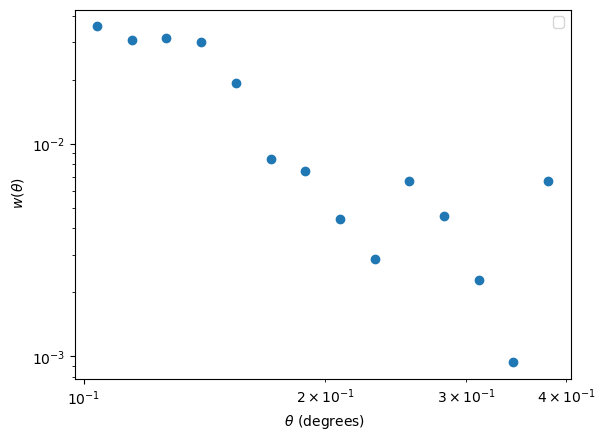

In [54]:
mask = (theta >= 0.1) & (theta <= 0.4)
plt.scatter(theta[mask], w_thetas[4][mask])
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [55]:
nz = hm.integrate_corr.flat_z_dist(np.min(z_values), np.max(z_values))
gg = hm.integrate_corr.AngularCF(nz,nz,theta_min= np.min(theta)*np.pi/180 ,theta_max=np.max(theta)*np.pi/180 ,theta_num = len(theta),zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values),p_of_z=True)
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}

## With mask
#gg.theta_min = np.min(theta[mask])*np.pi/180
#gg.theta_max = np.max(theta[mask])*np.pi/180


In [56]:
IC = []
ws= []


for i, result in enumerate(column_sums): 
    theta = np.array(theta)
    sum_rr = np.array(result['sum_rr'])
    
    # Integral Constraint
    IC_tmp = np.sum(gg.angular_corr_gal[i]* sum_rr[i])/np.sum(sum_rr[i])
    IC.append(IC_tmp)
    
    #!!! this here is approximative, i need to find the amplitude and delta for each of the subsample, i tried above (with pymc) but has failed till now
    w_fit = 2 * 1e-2 * theta**(-0.8)
    w_IC = np.sum(w_fit * sum_rr[i] / np.sum(sum_rr)) 
    w = w_thetas[i] - w_IC  # w_measured + w_IC 
    ws.append(w) 
    


In [59]:
sums = []
w_thetas_SN_E2 = []
w_thetas_SN_C3 = []
w_thetas_SN_X3 = []
w_thetas_COSMOS = []

for i in range(21):


    # Calculate sum for each field
    sum_dd_SN_E2 = data_SN_E2[:, 5]
    sum_rr_SN_E2 = data_SN_E2[:, 6]
    sum_dr_SN_E2 = data_SN_E2[:, 7]
    
    w_theta_SN_E2 = (sum_dd_SN_E2 - 2 * sum_dr_SN_E2 + sum_rr_SN_E2) / sum_rr_SN_E2
    w_thetas_SN_E2.append(w_theta_SN_E2)

    sum_dd_SN_C3 = data_SN_C3[:, 5]
    sum_rr_SN_C3 = data_SN_C3[:, 6]
    sum_dr_SN_C3 = data_SN_C3[:, 7]
    
    w_theta_SN_C3 = (sum_dd_SN_C3 - 2 * sum_dr_SN_C3 + sum_rr_SN_C3) / sum_rr_SN_C3
    w_thetas_SN_C3.append(w_theta_SN_C3)

    sum_dd_SN_X3 = data_SN_X3[:, 5]
    sum_rr_SN_X3 = data_SN_X3[:, 6]
    sum_dr_SN_X3 = data_SN_X3[:, 7]
    
    w_theta_SN_X3 = (sum_dd_SN_X3 - 2 * sum_dr_SN_X3 + sum_rr_SN_X3) / sum_rr_SN_X3
    w_thetas_SN_X3.append(w_theta_SN_X3)

    sum_dd_COSMOS = data_COSMOS[:, 5]
    sum_rr_COSMOS = data_COSMOS[:, 6]
    sum_dr_COSMOS = data_COSMOS[:, 7]
    
    w_theta_COSMOS = (sum_dd_COSMOS - 2 * sum_dr_COSMOS + sum_rr_COSMOS) / sum_rr_COSMOS
    w_thetas_COSMOS.append(w_theta_COSMOS)
    
    


# Example output for verification
for i in range(21):

    # Store sums and w_theta for each catalog
    sums.append({
        'catalog_index': i,
        'sum_dd_SN_E2': sum_dd_SN_E2,
        'sum_rr_SN_E2': sum_rr_SN_E2,
        'sum_dr_SN_E2': sum_dr_SN_E2,
        'w_theta_SN_E2': w_theta_SN_E2,
        
        'sum_dd_SN_C3': sum_dd_SN_C3,
        'sum_rr_SN_C3': sum_rr_SN_C3,
        'sum_dr_SN_C3': sum_dr_SN_C3,
        'w_theta_SN_C3': w_theta_SN_C3,
        
        'sum_dd_SN_X3': sum_dd_SN_X3,
        'sum_rr_SN_X3': sum_rr_SN_X3,
        'sum_dr_SN_X3': sum_dr_SN_X3,
        'w_theta_SN_X3': w_theta_SN_X3,
        
        'sum_dd_COSMOS': sum_dd_COSMOS,
        'sum_rr_COSMOS': sum_rr_COSMOS,
        'sum_dr_COSMOS': sum_dr_COSMOS,
        'w_theta_COSMOS': w_theta_COSMOS
    })
    
"""

# Print the results for each catalog
for result in sums:
    print(f"Subsample {result['catalog_index']}:")
    print(f"  w_theta_SN_E2: {result['w_theta_SN_E2']}")
    print(f"  w_theta_SN_C3: {result['w_theta_SN_C3']}")
    print(f"  w_theta_SN_X3: {result['w_theta_SN_X3']}")
    print(f"  w_theta_COSMOS: {result['w_theta_COSMOS']}")
    print()
"""




'\n\n# Print the results for each catalog\nfor result in sums:\n    print(f"Subsample {result[\'catalog_index\']}:")\n    print(f"  w_theta_SN_E2: {result[\'w_theta_SN_E2\']}")\n    print(f"  w_theta_SN_C3: {result[\'w_theta_SN_C3\']}")\n    print(f"  w_theta_SN_X3: {result[\'w_theta_SN_X3\']}")\n    print(f"  w_theta_COSMOS: {result[\'w_theta_COSMOS\']}")\n    print()\n'

### w_theta for all subsamples put together for each fields

In [60]:
w_thetas_SN_E2, w_theta_errors_SN_E2 = [], []
w_thetas_SN_C3, w_theta_errors_SN_C3 = [], []
w_thetas_SN_X3, w_theta_errors_SN_X3 = [], []
w_thetas_COSMOS, w_theta_errors_COSMOS = [], []

for i in range(21):
    # --- SN_E2 ---
    sum_dd_SN_E2 = data_SN_E2[:, 5]
    sum_rr_SN_E2 = data_SN_E2[:, 6]
    sum_dr_SN_E2 = data_SN_E2[:, 7]

    w_theta_SN_E2 = (sum_dd_SN_E2 - 2 * sum_dr_SN_E2 + sum_rr_SN_E2) / sum_rr_SN_E2
    w_thetas_SN_E2.append(w_theta_SN_E2)

    # Error calculation for SN_E2
    fractional_error_SN_E2 = 1 / np.sqrt(sum_dd_SN_E2)
    errorbars_SN_E2 = fractional_error_SN_E2 * (w_theta_SN_E2 + 1)
    w_theta_errors_SN_E2.append(errorbars_SN_E2)

    # --- SN_C3 ---
    sum_dd_SN_C3 = data_SN_C3[:, 5]
    sum_rr_SN_C3 = data_SN_C3[:, 6]
    sum_dr_SN_C3 = data_SN_C3[:, 7]

    w_theta_SN_C3 = (sum_dd_SN_C3 - 2 * sum_dr_SN_C3 + sum_rr_SN_C3) / sum_rr_SN_C3
    w_thetas_SN_C3.append(w_theta_SN_C3)

    # Error calculation for SN_C3
    fractional_error_SN_C3 = 1 / np.sqrt(sum_dd_SN_C3)
    errorbars_SN_C3 = fractional_error_SN_C3 * (w_theta_SN_C3 +1)
    w_theta_errors_SN_C3.append(errorbars_SN_C3)

    # --- SN_X3 ---
    sum_dd_SN_X3 = data_SN_X3[:, 5]
    sum_rr_SN_X3 = data_SN_X3[:, 6]
    sum_dr_SN_X3 = data_SN_X3[:, 7]

    w_theta_SN_X3 = (sum_dd_SN_X3 - 2 * sum_dr_SN_X3 + sum_rr_SN_X3) / sum_rr_SN_X3
    w_thetas_SN_X3.append(w_theta_SN_X3)

    # Error calculation for SN_X3
    fractional_error_SN_X3 = 1 / np.sqrt(sum_dd_SN_X3)
    errorbars_SN_X3 = fractional_error_SN_X3 * (w_theta_SN_X3 + 1)
    w_theta_errors_SN_X3.append(errorbars_SN_X3)

    # --- COSMOS ---
    sum_dd_COSMOS = data_COSMOS[:, 5]
    sum_rr_COSMOS = data_COSMOS[:, 6]
    sum_dr_COSMOS = data_COSMOS[:, 7]

    w_theta_COSMOS = (sum_dd_COSMOS - 2 * sum_dr_COSMOS + sum_rr_COSMOS) / sum_rr_COSMOS
    w_thetas_COSMOS.append(w_theta_COSMOS)

    # Error calculation for COSMOS
    fractional_error_COSMOS = 1 / np.sqrt(sum_dd_COSMOS)
    errorbars_COSMOS = fractional_error_COSMOS * (w_theta_COSMOS + 1)
    w_theta_errors_COSMOS.append(errorbars_COSMOS)

"""# Example output for verification
for i in range(5):  # Show first 5 samples
    print(f"Sample {i}:")
    print(f"  SN_E2 w(θ) = {w_thetas_SN_E2[i]}, Error = {w_theta_errors_SN_E2[i]}")
    print(f"  SN_C3 w(θ) = {w_thetas_SN_C3[i]}, Error = {w_theta_errors_SN_C3[i]}")
    print(f"  SN_X3 w(θ) = {w_thetas_SN_X3[i]}, Error = {w_theta_errors_SN_X3[i]}")
    print(f"  COSMOS w(θ) = {w_thetas_COSMOS[i]}, Error = {w_theta_errors_COSMOS[i]}")
"""

'# Example output for verification\nfor i in range(5):  # Show first 5 samples\n    print(f"Sample {i}:")\n    print(f"  SN_E2 w(θ) = {w_thetas_SN_E2[i]}, Error = {w_theta_errors_SN_E2[i]}")\n    print(f"  SN_C3 w(θ) = {w_thetas_SN_C3[i]}, Error = {w_theta_errors_SN_C3[i]}")\n    print(f"  SN_X3 w(θ) = {w_thetas_SN_X3[i]}, Error = {w_theta_errors_SN_X3[i]}")\n    print(f"  COSMOS w(θ) = {w_thetas_COSMOS[i]}, Error = {w_theta_errors_COSMOS[i]}")\n'

### Computing the Galaxy Bias with the Integral Constraint

Galaxy bias \( b \) describes how galaxies trace the underlying matter distribution and is crucial for connecting observed galaxy clustering to the underlying dark matter field.

When estimating galaxy bias, we typically use the two-point correlation function $ \xi_g(r)$ of galaxies and compare it to the matter correlation function $ \xi_m(r) $ via:

$
b^2(r) = \frac{\xi_g(r)}{\xi_m(r)}
$

However, observational constraints, such as the **integral constraint (IC)**, can introduce systematics in the measurement of $ \xi_g(r)$. The integral constraint arises because observational surveys measure fluctuations relative to the mean density in the finite survey volume, rather than the true mean density. The measured galaxy correlation function $ \xi_g^{\text{obs}}(r) $ is biased by a constant offset:

$
\xi_g^{\text{obs}}(r) = \xi_g(r) - C
$


This term accounts for the fact that the mean density of galaxies in the finite volume is used as an estimate of the true mean.


In [61]:
mask = (theta >= 0.1) & (theta <= 0.4)  # to get only the 2-halo term

# Integral Constraint Calculation
def IC(wg_no_ic, rr):
    return np.sum(wg_no_ic * rr) / np.sum(rr)

# Model Function
def model(wdm, b, IC_value):
    wg_no_ic = wdm * b**2  # Initial model without IC correction
    wg_model = wg_no_ic - IC_value  # Apply correction
    
    return wg_model[mask]   # to get only the 2-halo term

# Calculate IC values for each dataset
IC_SNC3 = IC(gg.angular_corr_gal, sum_rr_SN_C3)
IC_SNE2 = IC(gg.angular_corr_gal, sum_rr_SN_E2)
IC_SNX3 = IC(gg.angular_corr_gal, sum_rr_SN_X3)
IC_COSMOS = IC(gg.angular_corr_gal, sum_rr_COSMOS)


IC_list = [IC_SNC3, IC_SNE2, IC_SNX3, IC_COSMOS]

w_theta_list= [w_thetas_SN_C3, w_thetas_SN_E2, w_thetas_SN_X3, w_thetas_COSMOS]

w_theta_error_list=[w_theta_errors_SN_C3, w_theta_errors_SN_E2, w_theta_errors_SN_X3, w_theta_errors_COSMOS]

names = [ 'SN-C3', 'SN-E2','SN-X3','COSMOS']




b = []   # Bias values
be = []  # Bias errors

for i in range(4): 
    #matter_corr =  np.array(gg.angular_corr_matter)         # Theoretical matter correlation
    #galaxy_corr = w_thetas[i]                      # Observed galaxy correlation
    #galaxy_corr =  np.array(w_theta_list[i])
    #errors=  np.array(w_theta_error_list[i]) 
    IC_value = IC_list[i] 
    
    
    matter_corr = np.array(gg.angular_corr_matter).flatten()
    galaxy_corr = np.array(w_theta_list[i]).flatten()
    errors = np.array(w_theta_error_list[i]).flatten()

    min_len = min(len(matter_corr), len(galaxy_corr), len(errors))
    matter_corr = matter_corr[:min_len]
    galaxy_corr = galaxy_corr[:min_len]
    errors = errors[:min_len]
    
    #errors = (1 / np.sqrt(sum_dd[i])) * (galaxy_corr + 1)
    

    #popt, pcov = curve_fit(model, matter_corr, galaxy_corr, sigma=errors, absolute_sigma=True, p0=[1.0])
    
    # IC_value is fixed
    popt, pcov = curve_fit(lambda wdm, b: model(wdm, b, IC_value), matter_corr, galaxy_corr[mask], sigma=errors[mask], absolute_sigma=True, p0=[1.0])



    bias = popt[0]
    bias_error = np.sqrt(np.diag(pcov))[0]

    b.append(bias)
    be.append(bias_error)

    print(f" {names[i]}: Bias = {bias:.3f} ± {bias_error:.3f}")
    


 SN-C3: Bias = 2.416 ± 0.050
 SN-E2: Bias = 2.114 ± 0.070
 SN-X3: Bias = 1.768 ± 0.062
 COSMOS: Bias = 1.928 ± 0.059


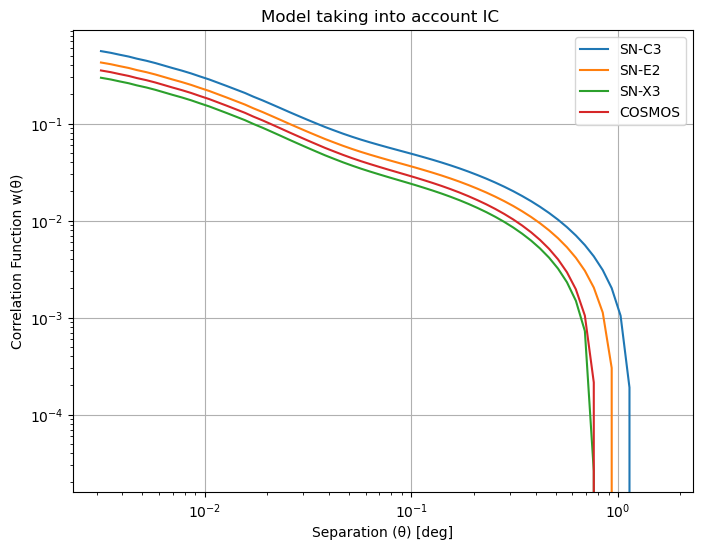

In [62]:
plt.figure(figsize=(8, 6))
for i in range(4):
    
    # model
    plt.plot(theta, gg.angular_corr_matter * b[i]**2 - IC_list[i], label=names[i])


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (θ) [deg]')
plt.ylabel('Correlation Function w(θ)')
plt.title('Model taking into account IC ') 
plt.grid(True)
plt.legend()
plt.show()




 SN-C3


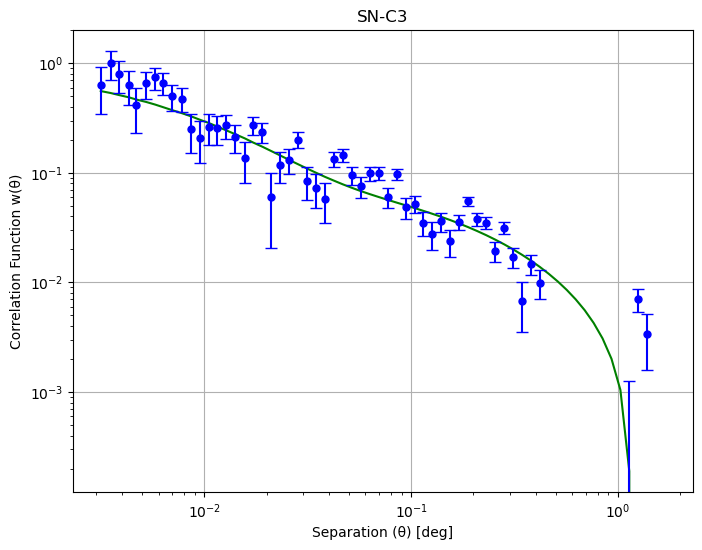

 SN-E2


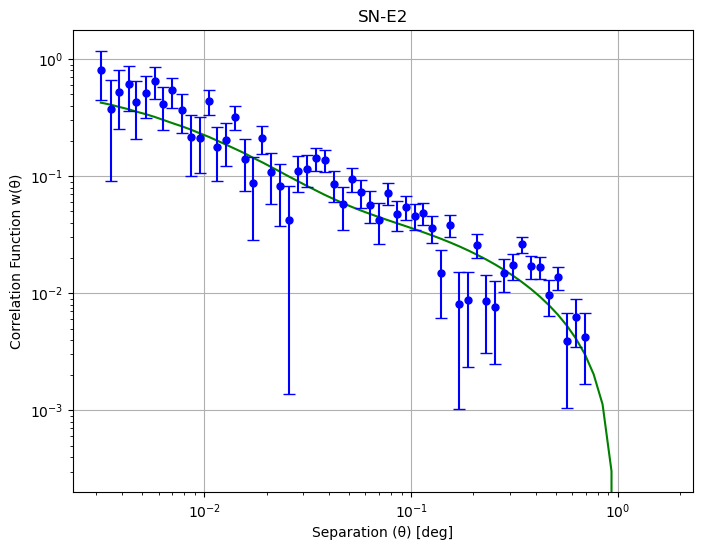

 SN-X3


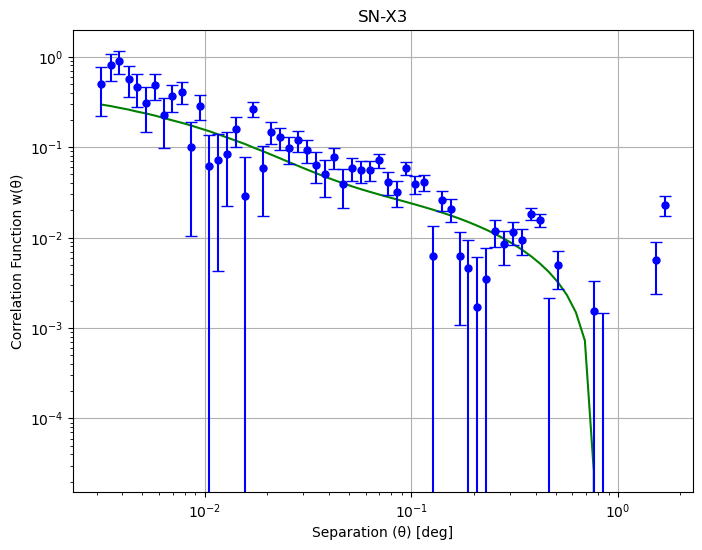

 COSMOS


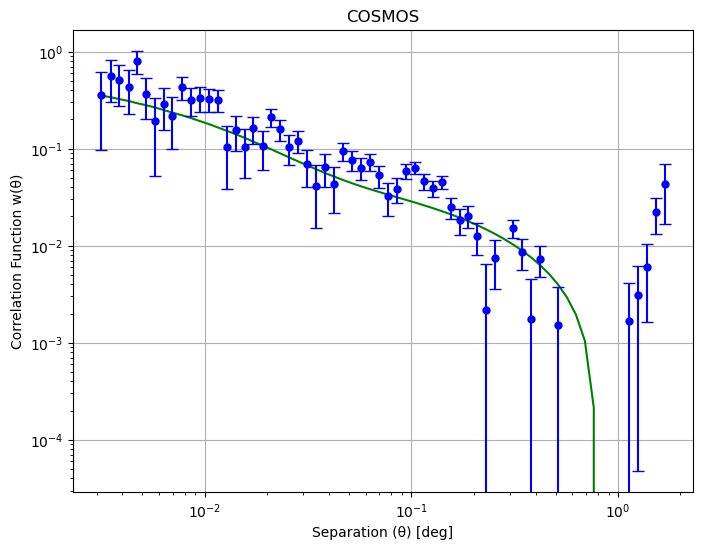

In [63]:

for i in range(4):
    print(f" {names[i]}")

    plt.figure(figsize=(8, 6)) 

    # Bias fit line
    plt.plot(theta, gg.angular_corr_matter * b[i]**2 - IC_list[i], label='Bias Fit', color='green')

    # Observed data without IC correction
    plt.errorbar(theta, w_theta_list[i][0], yerr=w_theta_error_list[i][0], fmt='o', color='blue', capsize=4, markersize=5)

    # Observed data with mask applied
    #plt.errorbar(theta[mask], w_thetas[i][mask], yerr=errors[i][mask], fmt='o', color='orange',  capsize=4, markersize=6)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Separation (θ) [deg]')
    plt.ylabel('Correlation Function w(θ)')
    plt.title(names[i])
    plt.grid(True)
    plt.show()


In [64]:
w_theta_list = [w_thetas_SN_C3, w_thetas_SN_E2, w_thetas_SN_X3, w_thetas_COSMOS]
w_theta_error_list = [w_theta_errors_SN_C3, w_theta_errors_SN_E2, w_theta_errors_SN_X3, w_theta_errors_COSMOS]
sum_rr_list = [sum_rr_SN_C3, sum_rr_SN_E2, sum_rr_SN_X3, sum_rr_COSMOS]
names = ['SN-C3', 'SN-E2', 'SN-X3', 'COSMOS']
mask = (theta >= 0.1) & (theta <= 0.4)  # to get only the 2-halo term

# Create an instance of BiasEstimator
bias_estimator = package.bias_estimator.BiasEstimator(gg, w_theta_list, w_theta_error_list, sum_rr_list, names, mask)

# Estimate bias values
b, be = bias_estimator.estimate_bias()

# Results are printed and stored in b (bias values) and be (bias errors)


SN-C3: Bias = 2.416 ± 0.050
SN-E2: Bias = 2.114 ± 0.070
SN-X3: Bias = 1.768 ± 0.062
COSMOS: Bias = 1.928 ± 0.059


In [65]:

names = ['COSMOS']
mask = (theta >= 0.1) & (theta <= 0.4)  # to get only the 2-halo term
for i in range(21):
    # Create an instance of BiasEstimator
    bias_estimator = package.bias_estimator.BiasEstimator(gg, w_thetas_COSMOS, w_theta_errors_COSMOS, sum_rr_COSMOS, names, mask)

    # Estimate bias values
    b, be = bias_estimator.estimate_bias()



COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003
COSMOS: Bias = 41.889 ± 0.003


In [66]:

# w_g(theta)= b**2 * w_dm(theta)
# w_g_obs(theta)= w_g(theta) - IC

def w_model(wdm, b):

    wg_no_ic = wdm * b**2  # Initial model without IC correction
    
    IC = np.sum(wg_no_ic * sum_rr)/np.sum(sum_rr)  # Integral constraint correction
    
    wg_model = wg_no_ic - IC # Apply correction
    
    return wg_model[mask]


In [69]:
def IC(wg_no_ic, rr):
    return np.sum(wg_no_ic * rr) / np.sum(rr)

# Model Function with Dynamic IC Calculation
def model(wdm, b, rr, angular_corr_gal):
    wg_no_ic = wdm * b**2                   # Initial model without IC correction
    IC_value = IC(angular_corr_gal, rr)     # Recalculate IC dynamically
    wg_model = wg_no_ic - IC_value          # Apply IC correction
    return wg_model[mask]                   # Apply mask if necessary

# Data for each field
rr_list = [sum_rr_SN_C3, sum_rr_SN_E2, sum_rr_SN_X3, sum_rr_COSMOS]  # Random pair counts
angular_corr_gal_list = []

for i in range(4):
    angular_corr_gal_list.append(gg.angular_corr_gal[i])  

    
    
# Lists to store bias values and errors
b = []
be = []

for i in range(4):
    matter_corr = gg.angular_corr_matter    # Theoretical matter correlation function
    galaxy_corr = w_thetas[i]               # Observed galaxy correlation function
    rr = rr_list[i]                         # Random-random pairs for this field
    angular_corr_gal = angular_corr_gal_list[i]  # Angular correlation data

    errors = (1 / np.sqrt(sum_dd[i])) * (galaxy_corr + 1)  # Error estimation

    # Curve fitting with IC recalculated inside the model
    model_with_dynamic_IC = lambda wdm, b: model(wdm, b, rr, angular_corr_gal)

    # Curve fit to determine bias
    popt, pcov = curve_fit(model_with_dynamic_IC, matter_corr, galaxy_corr[mask], 
                           sigma=errors[mask], absolute_sigma=True, p0=[1.0])

    # Extract bias and its error
    bias = popt[0]
    bias_error = np.sqrt(np.diag(pcov))[0]

    b.append(bias)
    be.append(bias_error)

    print(f"Subsample {i + 1}: Bias = {bias:.3f} ± {bias_error:.3f}")


Subsample 1: Bias = 12.504 ± 0.162
Subsample 2: Bias = 11.957 ± 0.147
Subsample 3: Bias = 11.453 ± 0.142
Subsample 4: Bias = 10.782 ± 0.140


In [70]:
biases = []
bias_errors = []
    
for i, result in enumerate(column_sums): 

    matter_corr = gg.angular_corr_matter  # Matter correlation function (theoretical values)
    galaxy_corr =  w_thetas[i] # Galaxy correlation function (observed values)


    errors = (1 / np.sqrt(sum_dd[i])) * (galaxy_corr+1)
    

    # Fit the model
    popt, pcov = curve_fit(w_model, matter_corr, galaxy_corr[mask], sigma=errors[mask], absolute_sigma=True, p0=1.0)

    # Extract the bias and its error
    bias = popt[0]  # Best-fit bias for this subsample
    bias_error = np.sqrt(np.diag(pcov))[0]  # Uncertainty in bias

    biases.append(bias)
    bias_errors.append(bias_error)

    print(f"Subsample {i + 1}:Bias: {bias:.3f} ± {bias_error:.3f}")



Subsample 1:Bias: 1.634 ± 1.841
Subsample 2:Bias: 1.729 ± 1.516
Subsample 3:Bias: 2.208 ± 1.093
Subsample 4:Bias: 1.077 ± 2.088
Subsample 5:Bias: 1.994 ± 1.053
Subsample 6:Bias: 2.452 ± 0.806
Subsample 7:Bias: 1.143 ± 1.512
Subsample 8:Bias: 1.695 ± 0.973
Subsample 9:Bias: 2.008 ± 0.752
Subsample 10:Bias: 1.117 ± 1.200
Subsample 11:Bias: 2.427 ± 0.557
Subsample 12:Bias: 2.798 ± 0.437
Subsample 13:Bias: 0.862 ± 1.253
Subsample 14:Bias: 2.367 ± 0.435
Subsample 15:Bias: 2.727 ± 0.354
Subsample 16:Bias: 0.740 ± 1.132
Subsample 17:Bias: 1.769 ± 0.459
Subsample 18:Bias: 2.195 ± 0.325
Subsample 19:Bias: 0.765 ± 0.856
Subsample 20:Bias: 1.693 ± 0.360
Subsample 21:Bias: 2.401 ± 0.236


# THESE PLOTS ARE REALLY GOOD, DON'T FORGET TO INCLUDE THEM

Subsample 1:


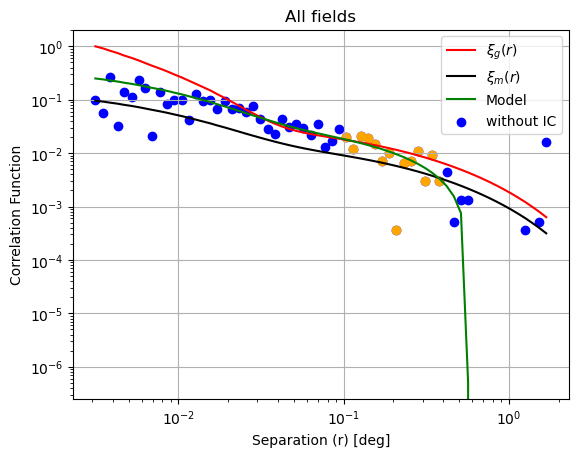

Subsample 2:


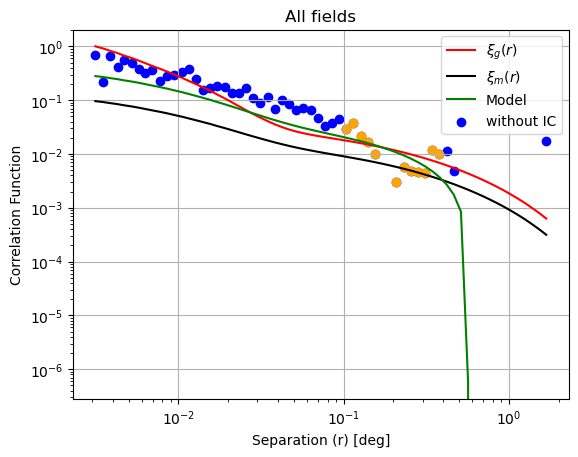

Subsample 3:


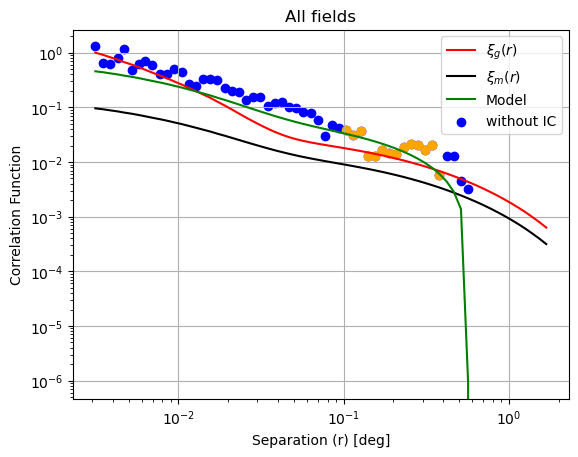

Subsample 4:


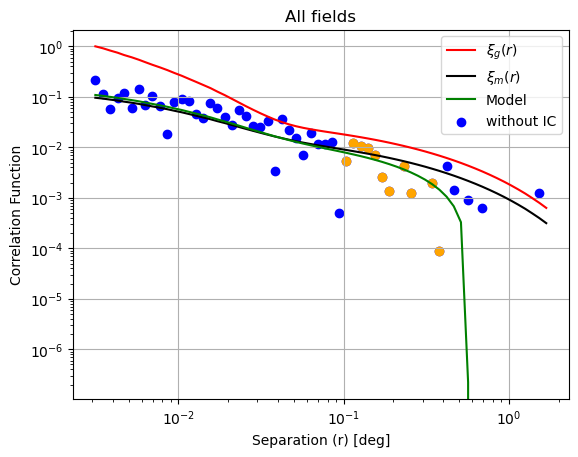

Subsample 5:


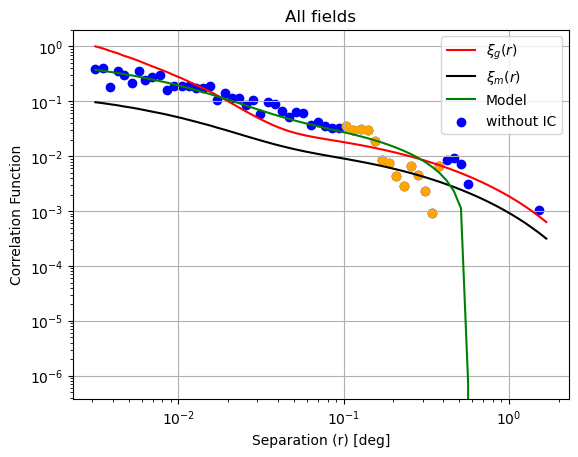

Subsample 6:


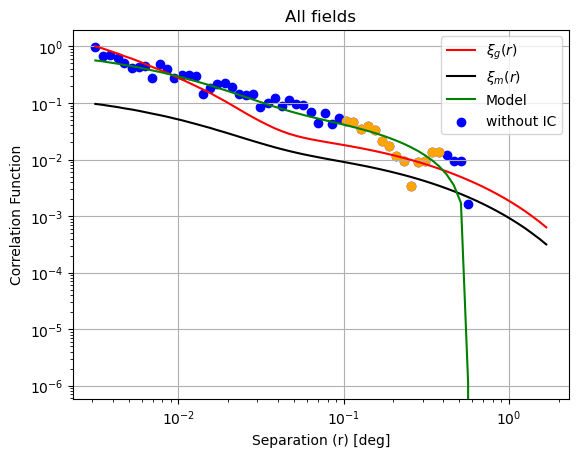

Subsample 7:


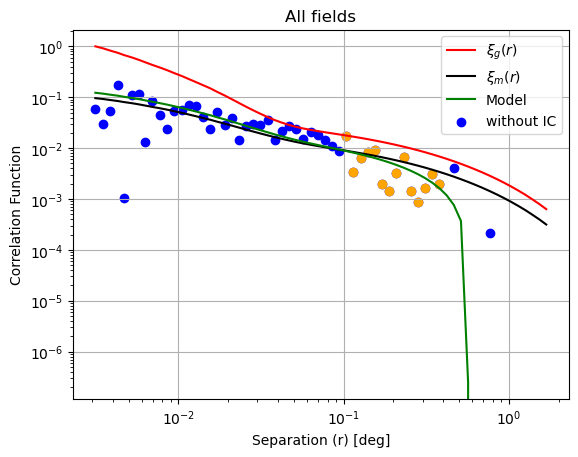

Subsample 8:


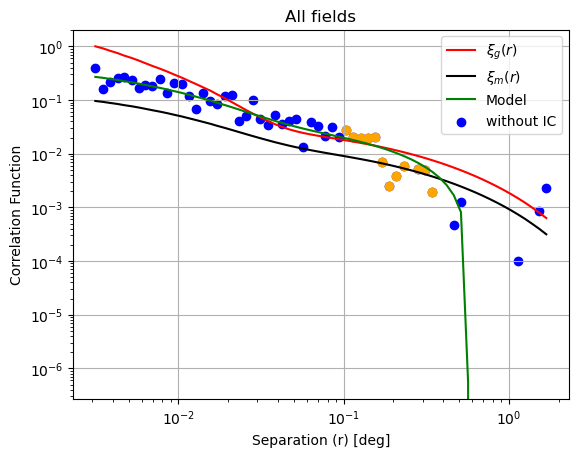

Subsample 9:


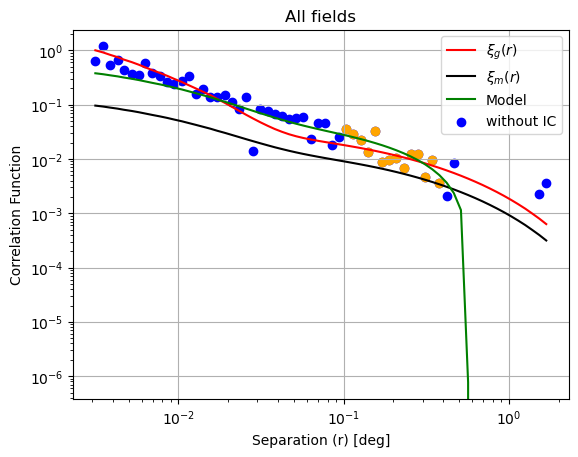

Subsample 10:


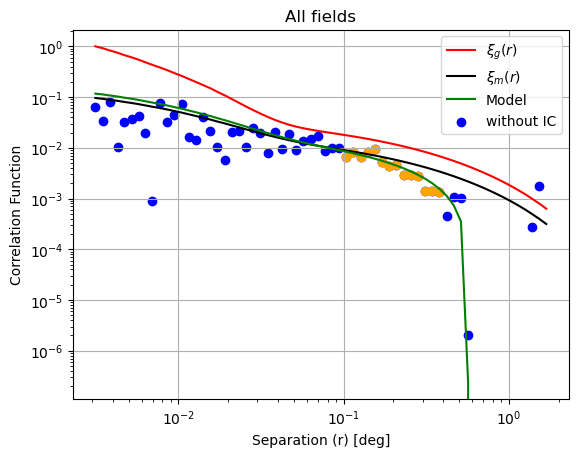

Subsample 11:


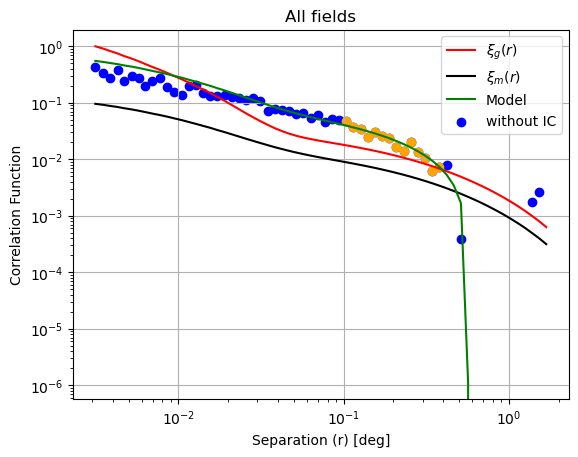

Subsample 12:


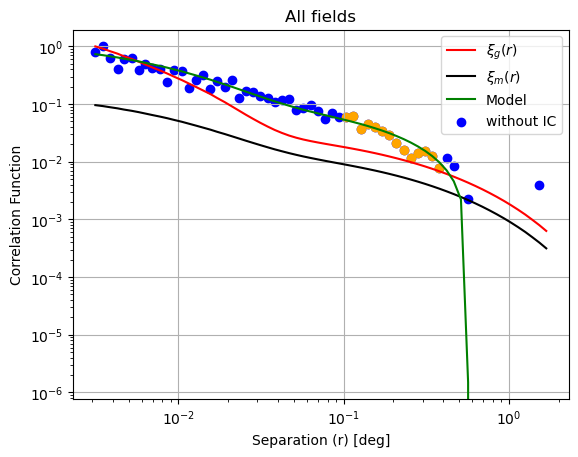

Subsample 13:


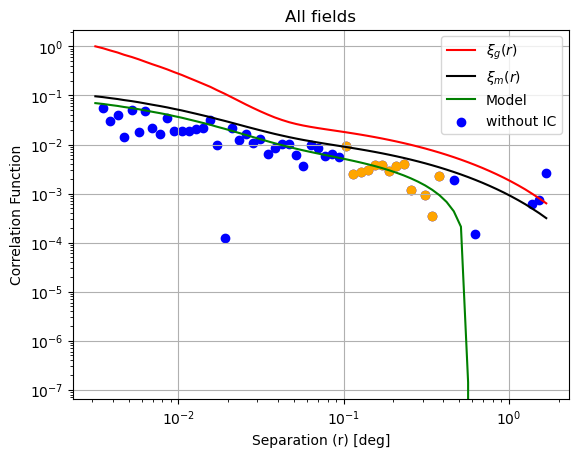

Subsample 14:


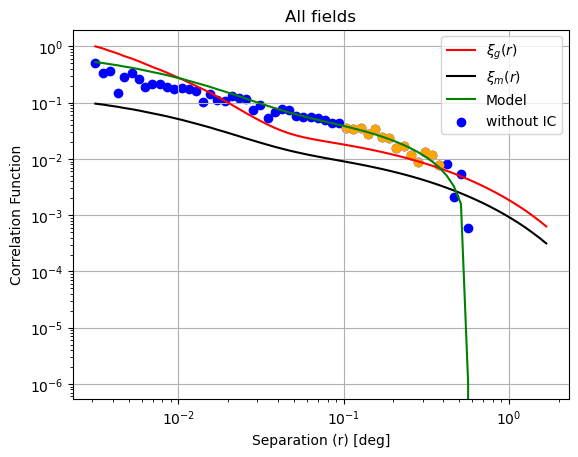

Subsample 15:


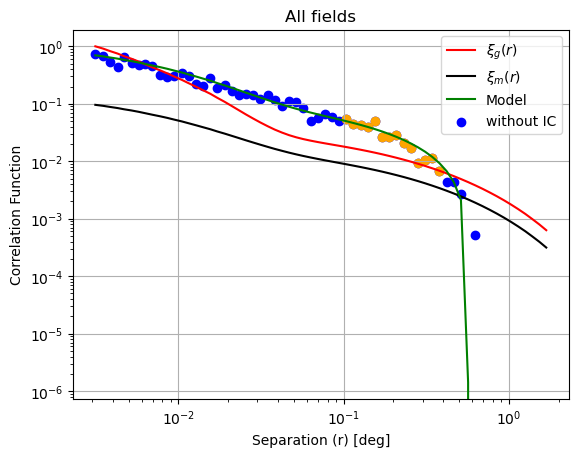

Subsample 16:


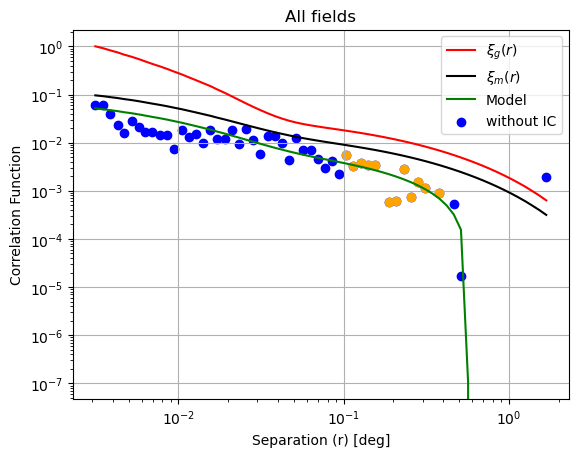

Subsample 17:


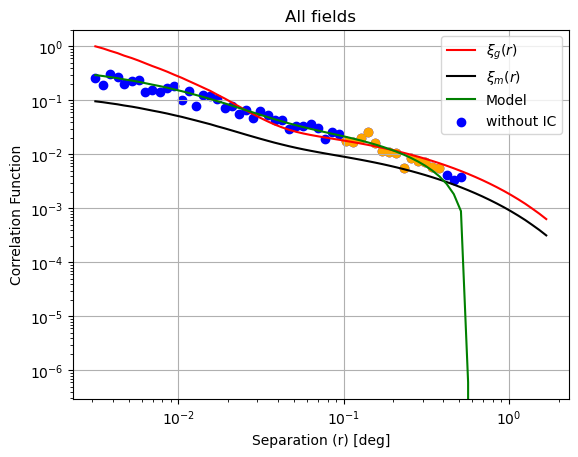

Subsample 18:


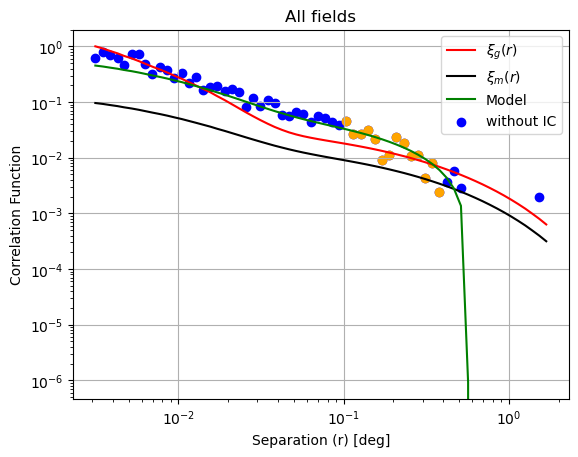

Subsample 19:


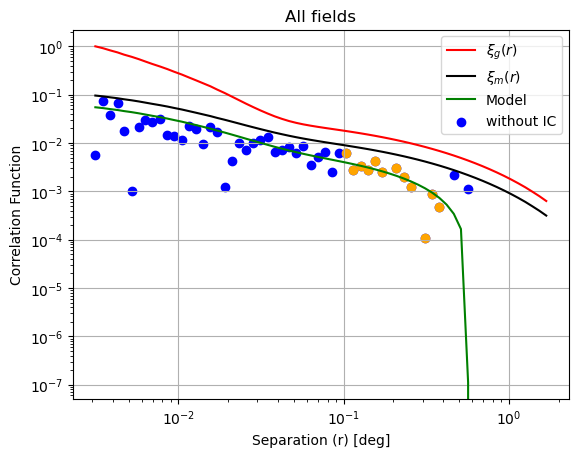

Subsample 20:


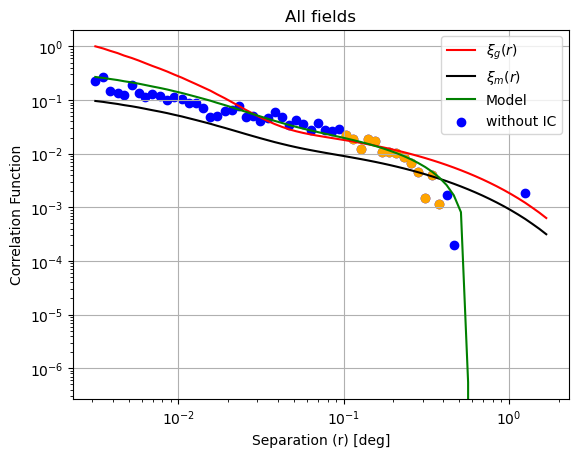

Subsample 21:


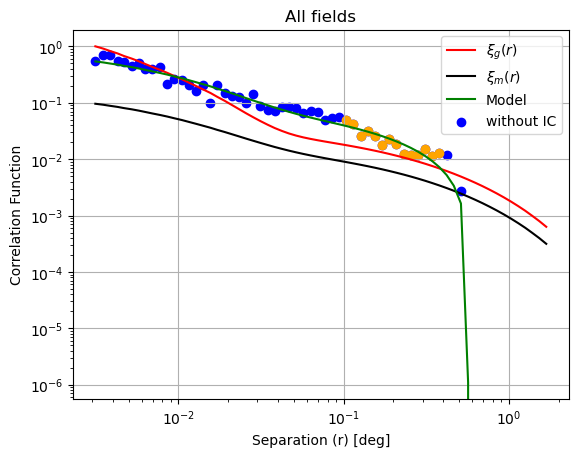

In [71]:
for i, result in enumerate(column_sums): 
    print(f"Subsample {result['catalog_index']+1}:")
    IC = np.sum( gg.angular_corr_matter*biases[i]**2 * sum_rr)/np.sum(sum_rr)

    plt.loglog(theta, gg.angular_corr_gal, label=r'$\xi_g(r)$', color='r')
    plt.loglog(theta, gg.angular_corr_matter, label=r'$\xi_m(r)$', color='k')
    plt.loglog(theta, gg.angular_corr_matter*biases[i]**2 -IC, label=r'Model', color='g')
    
    plt.scatter(theta, w_thetas[i], marker='o', label='without IC', color='blue')  # without IC
    plt.scatter(theta[mask], w_thetas[i][mask], marker='o', color='orange')  # 2 halo term

    plt.xlabel('Separation (r) [deg]')
    plt.ylabel('Correlation Function')
    plt.legend()
    plt.title('All fields')
    plt.savefig(os.path.join(res, "Model_with_IC"))

    plt.grid(True)
    plt.show()

In [ ]:
for i, result in enumerate(column_sums): 
    print(f"Subsample {result['catalog_index']}:")

    plt.scatter(theta,ws[i], label='IC corrected', color='orange')  #!!! this here for y-axis is approximative, i need to find the amplitude and delta for each of the subsample, i tried above (with pymc) but has failed till now

    plt.scatter(theta, w_thetas[i], marker='o', label='without IC', color='blue')  # without IC
    
    plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='CF of DM')
    plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='HOD fit')
    
    #plt.plot(gg.theta*180/np.pi, (gg.angular_corr_matter-IC[i])*(biases[i])**2, color='forestgreen',label='Fit for bias with IC')
    plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter*(biases[i]**2), color='forestgreen',label='Fit for bias with IC')

    

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("theta")
    plt.ylabel("w_theta")
    plt.legend()
    plt.show()"""


In [ ]:
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

In [ ]:
    
z_values = np.arange(0.3, 1.1, 0.1)  ### be careful about completness issues, maybe stop at 0.4 for high SM

#SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM
SM_range = np.linspace(8, 11, num=4) # diff SM
m = np.unique(SM_mean_range) # Get the unique SM values
z= z_mean_range

print('len(m):',len(m))
print('len(z):',len(z))

zm=np.meshgrid(m,z)
np.array(zm)
zm=np.array(zm).reshape(2,-1)
zm[:,0]


avg_bias = np.reshape(biases, (len(z), len(m))).T

avg_bias_error= np.reshape(bias_errors, (len(z), len(m))).T

plt.figure(figsize=(10, 8)) 

for i in range(len(m)):
    plt.errorbar(z, avg_bias[i], yerr= avg_bias_error[i], label=f" SM = {m[i]:.2f}",marker='o',capsize=7)
    #plt.plot(z, avg_bias[i],  label=f" SM = {m[i]:.2f}",marker='o')
plt.title('Average Bias vs. Redshift (for the 4 fields)')
plt.xlabel('Redshift')
plt.ylabel('Average Bias')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(res,'Avgerage_bias'))
plt.show()

In [ ]:

COSMOS_reshaped = np.reshape(np.array(COSMOS[:, 1]), (len(z), len(m))).T  
X3_reshaped = np.reshape(np.array(X3[:, 1]), (len(z), len(m))).T  
E2_reshaped = np.reshape(np.array(E2[:, 1]), (len(z), len(m))).T  
C3_reshaped = np.reshape(np.array(C3[:, 1]), (len(z), len(m))).T  

In [ ]:
i_max = np.argmax(m)
plt.figure(figsize=(10, 8)) 

plt.errorbar(z, avg_bias[i_max], yerr= avg_bias_error[i_max], label=f"Average", color= 'black',marker='o',capsize=7)

plt.errorbar(z, C3_reshaped[i_max], yerr=C3[:, 2][i_max], label=f"SN-C3: SM = {m[i_max]:.2f}",marker="^", linestyle='dashed',capsize=7)
plt.errorbar(z, COSMOS_reshaped[i_max], yerr=COSMOS[:, 2][i_max], label=f"COSMOS:SM = {m[i_max]:.2f}", marker='o', capsize=7)
plt.errorbar(z, X3_reshaped[i_max],yerr=X3[:, 2][i_max],  label=f"X3: SM = {m[i_max]:.2f}",marker="D",linestyle='dotted',capsize=7)
plt.errorbar(z, E2_reshaped[i_max],yerr=E2[:, 2][i_max],  label=f"E3: SM = {m[i_max]:.2f}",marker="X",linestyle='dashdot',capsize=7)



# Add labels, title, grid, and legend
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs Redshift (Maximum Stellar Mass)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
i_min = np.argmin(m)
plt.figure(figsize=(10, 8)) 

plt.errorbar(z, avg_bias[i_min], yerr= avg_bias_error[i_min], label=f"Average", color= 'black',marker='o',capsize=7)

plt.errorbar(z, C3_reshaped[i_min], yerr=C3[:, 2][i_min], label=f"SN-C3: SM = {m[i_min]:.2f}",marker="^", linestyle='dashed',capsize=7)
plt.errorbar(z, COSMOS_reshaped[i_min], yerr=COSMOS[:, 2][i_min], label=f"COSMOS:SM = {m[i_min]:.2f}", marker='o', capsize=7)
plt.errorbar(z, X3_reshaped[i_min],yerr=X3[:, 2][i_min],  label=f"X3: SM = {m[i_min]:.2f}",marker="D",linestyle='dotted',capsize=7)
plt.errorbar(z, E2_reshaped[i_min],yerr=E2[:, 2][i_min],  label=f"E3: SM = {m[i_min]:.2f}",marker="X",linestyle='dashdot',capsize=7)



plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs Redshift (Minimum Stellar Mass)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
i_middle = len(m) // 2  # Middle index of m

plt.figure(figsize=(10, 8))

plt.errorbar(z, avg_bias[i_middle], yerr=avg_bias_error[i_middle], label=f"Average", color='black', marker='o', capsize=7)

plt.errorbar(z, C3_reshaped[i_middle], yerr=C3[:, 2][i_middle], label=f"SN-C3: SM = {m[i_middle]:.2f}", marker="^", linestyle='dashed', capsize=7)
plt.errorbar(z, COSMOS_reshaped[i_middle], yerr=COSMOS[:, 2][i_middle], label=f"COSMOS: SM = {m[i_middle]:.2f}", marker='o', capsize=7)
plt.errorbar(z, X3_reshaped[i_middle], yerr=X3[:, 2][i_middle], label=f"X3: SM = {m[i_middle]:.2f}", marker="D", linestyle='dotted', capsize=7)
plt.errorbar(z, E2_reshaped[i_middle], yerr=E2[:, 2][i_middle], label=f"E3: SM = {m[i_middle]:.2f}", marker="X", linestyle='dashdot', capsize=7)

plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs Redshift (Middle Stellar Mass)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 8)) 

for i in range(len(m)):
    plt.errorbar(z, avg_bias[i], yerr= avg_bias_error[i], label=f"Average",marker='o', color= 'black',capsize=7)

    plt.errorbar(z, COSMOS_reshaped[i],yerr=COSMOS[:, 2][i],  label=f"COSMOS: SM = {m[i]:.2f}",marker='o',capsize=7)
    plt.errorbar(z, X3_reshaped[i],yerr=X3[:, 2][i],  label=f"X3: SM = {m[i]:.2f}",marker="D",linestyle='dotted',capsize=7)
    plt.errorbar(z, E2_reshaped[i],yerr=E2[:, 2][i],  label=f"E2: SM = {m[i]:.2f}",marker="X",linestyle='dashdot',capsize=7)
    
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(res,"Bias_vs_z_for_diff_SM.png"))

plt.show()